# Harikrishna Dev HXD220000

In [1]:
# If in Colab, then import the drive module from google.colab
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output

  !pip install torchtext -qq
  # Install the torchinfo library quietly
  !pip install torchinfo -qq
  # !pip install torchtext --upgrade -qq
  !pip install torchmetrics -qq
  !pip install torchinfo -qq
  !pip install fast_ml -qq
  !pip install joblib -qq
  !pip install sklearn -qq
  !pip install pandas -qq
  !pip install numpy -qq
  !pip install scikit-multilearn -qq
  !pip install transformers evaluate wandb accelerate -U -qq
  !pip install pytorch-ignite -qq -U

  basepath = '/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing'
  sys.path.append('/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')
else:
  basepath = '/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/'
  sys.path.append('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Custom_files')
  # !pip install torchtext -qq
  # # Install the torchinfo library quietly
  # !pip install torchinfo -qq
  # !pip install torchtext --upgrade -qq
  # !pip install torchmetrics -qq
  # !pip install torchinfo -qq
  # !pip install fast_ml -qq
  # !pip install joblib -qq
  # !pip install sklearn -qq
  # !pip install pandas -qq
  # !pip install numpy -qq
  # !pip install scikit-multilearn -qq
  # !pip install transformers evaluate wandb accelerate -U -qq

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 1.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.2 MB/s eta 0:00:00
     ━━

*Import Libraries*

In [2]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn


# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab
from torchinfo import summary

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Printing: Import the pprint function from the pprint module for formatted output of text
from pprint import pprint

*Specify Project Folders*

In [3]:
# Set the base folder path using the Path class for better path handling
base_folder = Path(basepath)

# Define the data folder path by appending the relative path to the base folder
# This is where the data files will be stored
data_folder = base_folder / '0_Data_Folder'

# Define the model folder path for saving trained models
# This path points to a specific folder designated for NLP models related to the IMDb dataset
model_folder = data_folder

custom_functions = base_folder / '0_Custom_files'


In [4]:
# Create the model folder directory. If it already exists, do nothing.
# The 'parents=True' argument ensures that all parent directories are created if they don't exist.
model_folder.mkdir(exist_ok=True, parents=True)

# Create the data folder directory in a similar manner.
data_folder.mkdir(exist_ok=True, parents=True)


In [5]:
X_train_cleaned_file = data_folder / 'df_multilabel_hw_cleaned.joblib'

data = joblib.load(X_train_cleaned_file)

In [6]:
data.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [7]:
data.describe()

,cleaned_text,Tags,Tag_Number
count,47427,47427,47427
unique,36481,176,176
top,cause error targetcontrolid valid value null...,javascript jquery,"[3, 5]"
freq,3,19989,19989


<Axes: >

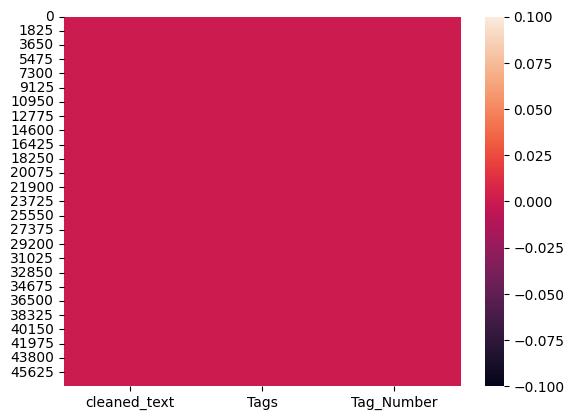

In [8]:
import seaborn as sns
sns.heatmap(data.isnull())

In [9]:
data['Tag_Number'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 47427 entries, 0 to 47426
Series name: Tag_Number
Non-Null Count  Dtype 
--------------  ----- 
47427 non-null  object
dtypes: object(1)
memory usage: 370.6+ KB


In [10]:
data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number'], dtype='object')

In [11]:
# def extract_and_combine(row):
#     langs = row['Tags'].split()
#     tags = row['Tag_Number']
#     return [f'{lang} {tag}' for lang, tag in zip(langs, tags)]
# result = data.apply(extract_and_combine, axis=1)
# result

In [12]:
import ast
y_tag = []
x = []

for i in range(data.shape[0]):
    y_tag.append(ast.literal_eval(data['Tag_Number'][i]))
    x.append(str(data['cleaned_text'][i]))

x = np.array(x).reshape(-1,1)

In [13]:
x[:5]

array([['asp query stre dropdown webpage follow control relevance    dropdownlist value hyperlink redirect page call   page cancel button redirect user menu page like user click hyperlink edit page index dropdownlist preserve query string page follow aspx code sure proceed < asp hyperlink      id="lnkedit      navigateurl=\'<% + eval("userid + sure > < /asp hyperlink >   < asp dropdownlist      id="mydropdown      < asp listitems/ > < /asp dropdownlist >   edit clarify m navigateurl query string eval determine user id'],
       ['run javascript code server java code want run javascript code server want manipulate result return javascript inside java code'],
       ['linq sql throw exception row find change hi linq sql get error row find change update table help linq query show error unable figure problem work get permanent solution fix problem twtmob_campainincomedetails_tb incomedetails = datacontext.twtmob_campainincomedetails_tbs single(twtincome = > = = tempincome                  

In [14]:
y_tag[:5]

[[0, 9], [1, 3], [0, 9], [2, 7], [3, 5]]

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y = mlb.fit_transform(y_tag)

print(type(y) , y.shape)
print(type(x) , x.shape)

<class 'numpy.ndarray'> (47427, 10)
<class 'numpy.ndarray'> (47427, 1)


In [16]:
y[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])

In [17]:
type(x)

numpy.ndarray

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Further split the testing set into validation and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=False)

In [19]:
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading text and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
    """

    def __init__(self, X, y):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
        """
        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y = y

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the text for the sample.
        """
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample


In [20]:
# Create an instance of the CustomDataset class for the training set
# This uses the cleaned training data and corresponding labels
trainset = CustomDataset(X_train, y_train)

# Create an instance of the CustomDataset class for the validation set
# This uses the cleaned validation data and corresponding labels
validset = CustomDataset(X_valid, y_valid)

# Create an instance of the CustomDataset class for the test set
# This uses the cleaned test data and corresponding labels
testset = CustomDataset(X_test, y_test)


In [21]:
def get_vocab(dataset, min_freq=1):
    """
    Generate a vocabulary from a dataset.

    Args:
        dataset (list of tuple): List of tuples where each tuple contains a label and a text.
        min_freq (int): The minimum frequency for a token to be included in the vocabulary.

    Returns:
        torchtext.vocab.Vocab: Vocabulary object.
    """
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (_, text) in dataset:
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab

In [22]:
code_vocab = get_vocab(trainset,min_freq=2)

In [23]:
len(code_vocab)

123505

In [24]:
code_vocab.get_itos()[0:5]

['<unk>', "['javascript", 'operator', 'puzzle', 'friend']

In [25]:
# Creating a function that will be used to get the indices of words from vocab
def tokenizer(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(x).split()]

In [26]:
def collate_batch(batch, my_vocab):
    """
    Collates a batch of samples into tensors of labels, texts, and offsets.

    Parameters:
        batch (list): A list of tuples, each containing a label and a text.

    Returns:
        tuple: A tuple containing three tensors:
               - Labels tensor
               - Concatenated texts tensor
               - Offsets tensor indicating the start positions of each text in the concatenated tensor
    """
    # Unpack the batch into separate lists for labels and texts
    labels, texts = zip(*batch)

    # Convert the list of labels into a tensor of dtype int32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Convert the list of texts into a list of lists; each inner list contains the vocabulary indices for a text
    list_of_list_of_indices = [tokenizer(text, my_vocab) for text in texts]

    # Compute the offsets for each text in the concatenated tensor
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # Concatenate all text indices into a single tensor
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    return (texts, offsets), labels

In [27]:
batch_size = 2
collate_partial = partial(collate_batch, my_vocab = code_vocab)
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           collate_fn=collate_partial,
                                           )

In [28]:
torch.manual_seed(22)
for (text, offset), label in check_loader:
    print(text, offset, label)
    break

tensor([ 5570,   834,   376,  2522,   125,    84,  1782,    71,    21,   368,
         1257,   472,   323,   376,  4613,    84,    21,   368,    52,  1817,
           71,    84,  2989,    42,   848,   834,   376,    84,    21,   368,
          754, 66439,   376,   125,   231,   834,   376,  2522,  4025,    86,
         3777,  3777,  1099,    71,   340,   838,   344,  1091,   324,   157,
          804,    90,   889,    87,    66,   344,     0,   839, 29573, 29574,
           68,    90,   376,    84,   666,   125,     5,  3224,     4,    66,
          351, 29575, 29576,    68,    66,    82,    68, 29577,    32,   376,
        29578, 17622,   167,   592, 29579,     0, 13749,    59,   530,   572,
           40,   262,   530,   913,   572,  3045,   913,   650,   237,    20,
          790,  8799,   572,  3045,  8799,  1018, 29580,   572,   646, 29580,
         3855,  9473,    71, 29581, 29582,   323,   264,     0,     5,   510,
            4,  3224,    31,  4220,    32,   510,   510,   666, 

<ipython-input-26-23e46644e366>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  labels = torch.tensor(labels, dtype=torch.float32)


In [29]:
class CustomBlock(nn.Module):
    def __init__(self, input_dim, output_dim, drop_prob):

        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(num_features=output_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),

        )
    def forward(self, x):
      return self.layers(x)
class EmbeddingBagWrapper(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)

    def forward(self, input_tuple):
        data, offsets = input_tuple
        return self.embedding_bag(data, offsets)

In [30]:
from functools import partial

# Define hyperparameters
EMBED_DIM = 300
VOCAB_SIZE = len(code_vocab)
OUTPUT_DIM = 10
HIDDEN_DIM1 = 200
HIDDEN_DIM2 = 100
OUTPUT_DIM = 10
EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
CLIP_TYPE = 'value'
CLIP_VALUE = 10
PATIENCE = 5
dropout_p = 0.3

# Define collate function
collate_fn = partial(collate_batch, my_vocab=code_vocab)

In [31]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the model

# Define the sequential model
vocab_size = len(code_vocab)
model = nn.Sequential(
    EmbeddingBagWrapper(vocab_size, EMBED_DIM),
    CustomBlock(EMBED_DIM , HIDDEN_DIM1, 0.5),
    CustomBlock(HIDDEN_DIM1, HIDDEN_DIM2, 0.5),
    nn.Linear(HIDDEN_DIM2, OUTPUT_DIM)
    )

In [32]:
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─EmbeddingBagWrapper: 1-1               --
│    └─EmbeddingBag: 2-1                 37,051,500
├─CustomBlock: 1-2                       --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-1                  60,200
│    │    └─BatchNorm1d: 3-2             400
│    │    └─ReLU: 3-3                    --
│    │    └─Dropout: 3-4                 --
├─CustomBlock: 1-3                       --
│    └─Sequential: 2-3                   --
│    │    └─Linear: 3-5                  20,100
│    │    └─BatchNorm1d: 3-6             200
│    │    └─ReLU: 3-7                    --
│    │    └─Dropout: 3-8                 --
├─Linear: 1-4                            1,010
Total params: 37,133,410
Trainable params: 37,133,410
Non-trainable params: 0

In [33]:
# torch.cuda.empty_cache()

In [34]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = torch.randint(0, 10, (5,), dtype=torch.int32, device=device)
offsets = torch.randint(0, 10, (3,), dtype=torch.int32, device=device)

In [35]:
output = model((data, offsets))

print(output)

tensor([[-0.1828, -0.1633, -0.4071, -0.3960,  0.6121, -0.4386,  0.2633,  0.1968,
          1.6521, -1.0182],
        [ 0.0170,  0.2013,  0.3220,  0.0857,  0.6200,  0.2660,  0.3327, -0.8145,
          0.2622, -0.6556],
        [ 0.8316, -0.4991,  0.4440, -0.3056,  0.8035,  0.6186, -0.2708,  0.5663,
         -0.3139, -0.3193]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [36]:
from torchmetrics import HammingDistance

def step(inputs, targets, model, device, loss_function=None, optimizer=None,clip_type='value',clip_value=10.0):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - train_hamming_distance (torchmetrics.HammingDistance): The Hamming distance metric.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs, targets = tuple(input_tensor.to(device) for input_tensor in inputs), targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Update Hamming Distance metric
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    y_pred = (outputs > 0.5).float()
    train_hamming_distance.update(y_pred, targets)

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        if clip_type == 'value':
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, train_hamming_distance
    else:
        return outputs, train_hamming_distance


In [37]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - epoch_hamming_distance (float): Hamming distance for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Initialize Hamming Distance metric
    hamming = HammingDistance(task="multilabel", num_labels=10).to(device)

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Move data to the appropriate device
        inputs, targets = tuple(input_tensor.to(device) for input_tensor in inputs), targets.to(device)

        # Perform a forward and backward pass, updating model parameters
        loss, _, _ = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss
        running_train_loss += loss.item()

        # Compute Hamming Distance for the epoch
        y_pred = (model(inputs) > 0.5).float()
        hamming.update(y_pred, targets)

    # Compute average loss for the entire training set
    train_loss = running_train_loss / len(train_loader)

    # Compute Hamming Distance for the epoch
    epoch_hamming_distance = hamming.compute()

    return train_loss, epoch_hamming_distance

In [38]:
from torchmetrics import HammingDistance

def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_hamming_distance (float): Hamming distance for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and Hamming Distance
    running_val_loss = 0.0
    val_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Move data to the appropriate device
            inputs, targets = tuple(input_tensor.to(device) for input_tensor in inputs), targets.to(device)

            # Perform a forward pass to get loss and number of correct predictions
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # Update running loss
            running_val_loss += loss.item()

            # Update Hamming Distance metric
            val_hamming_distance.update(torch.round(torch.sigmoid(outputs)), targets)

    # Compute average loss and Hamming Distance for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_hamming_distance = val_hamming_distance.compute()

    return val_loss, val_hamming_distance

## <Font color = 'indianred'>*7.4. train() function*

In [39]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience=5):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).
    - patience (int): Number of epochs to wait for improvement before early stopping.

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_hamm_history (list): History of training Hamming distance for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_hamm_history (list): History of validation Hamming distance for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_hamm_history = []
    valid_hamm_history = []

    # Initialize variables for early stopping
    best_valid_loss = float('inf')
    no_improvement = 0

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_hamm = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_hamm = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_hamm_history.append(train_hamm)
        valid_hamm_history.append(valid_hamm)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Hamming Distance: {train_hamm:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Hamming Distance: {valid_hamm:.4f}")
        print()

        # Check for early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement == patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break

    return train_loss_history, train_hamm_history, valid_loss_history, valid_hamm_history

In [40]:
# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.0
PATIENCE=10

In [41]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)                     # Set seed for Python's 'random' module
np.random.seed(SEED)                  # Set seed for NumPy's random number generation
torch.manual_seed(SEED)               # Set seed for PyTorch's CPU operations
torch.cuda.manual_seed(SEED)          # Set seed for PyTorch's CUDA (GPU) operations
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior in CuDNN

# Define collate function with a fixed vocabulary using the 'partial' function
collate_fn = partial(collate_batch, my_vocab=code_vocab)

# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Loaders for training, validation, and test sets
# These loaders handle batching, shuffling, and data processing using the custom collate function
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False,
                                          collate_fn=collate_fn, num_workers=4)

# Define the loss function for the model, using cross-entropy loss
loss_function = nn.BCEWithLogitsLoss()

# Define the model with specified hyperparameters
vocab_size = len(code_vocab)
model = nn.Sequential(
    EmbeddingBagWrapper(vocab_size, EMBED_DIM),
    CustomBlock(EMBED_DIM , HIDDEN_DIM1, 0.5),
    CustomBlock(HIDDEN_DIM1, HIDDEN_DIM2, 0.5),
    nn.Linear(HIDDEN_DIM2, OUTPUT_DIM)
    )
model = model.to(device)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


In [42]:
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(device)
    model = model.to(device)
    model.eval()
    # Forward pass
    with torch.no_grad():  # Ensure no gradients are calculated since this is evaluation.
        output = model(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')


Actual loss: 0.6948241591453552
Expected Theoretical loss: 0.6931471805599453


In [43]:
CLIP_VALUE = 10
# Call the train function to train the model
train_losses, train_hamm, valid_losses, valid_hamm = train(
    train_loader, valid_loader, model, optimizer, loss_function, EPOCHS, device, patience=PATIENCE
)

Epoch 1/5
Train Loss: 0.2676 | Train Hamming Distance: 0.1009
Valid Loss: 0.1614 | Valid Hamming Distance: 0.0596

Epoch 2/5
Train Loss: 0.1528 | Train Hamming Distance: 0.0568
Valid Loss: 0.1332 | Valid Hamming Distance: 0.0498

Epoch 3/5
Train Loss: 0.1251 | Train Hamming Distance: 0.0462
Valid Loss: 0.1193 | Valid Hamming Distance: 0.0447

Epoch 4/5
Train Loss: 0.1058 | Train Hamming Distance: 0.0395
Valid Loss: 0.1099 | Valid Hamming Distance: 0.0403

Epoch 5/5
Train Loss: 0.0921 | Train Hamming Distance: 0.0346
Valid Loss: 0.1062 | Valid Hamming Distance: 0.0383



**Plot losses and metrics**




In [44]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()



In [45]:
train_hamm

[tensor(0.1009, device='cuda:0'),
 tensor(0.0568, device='cuda:0'),
 tensor(0.0462, device='cuda:0'),
 tensor(0.0395, device='cuda:0'),
 tensor(0.0346, device='cuda:0')]

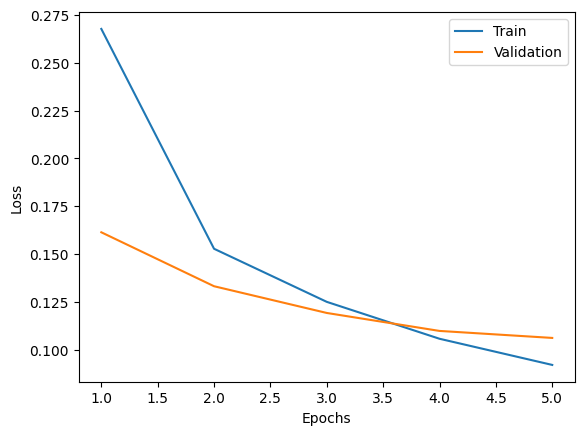

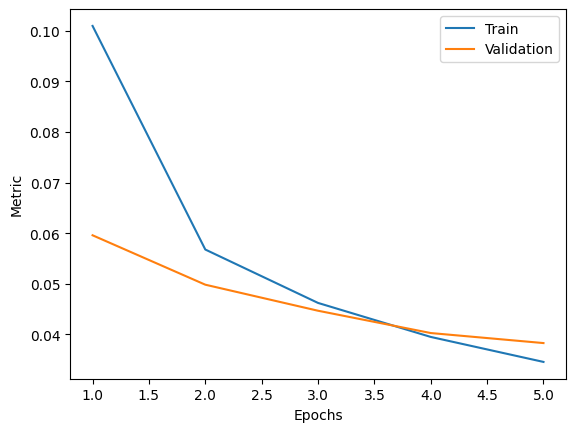

In [46]:
import numpy as np
# Plot the training and validation losses and metrics
train_hamm_np = [ham.cpu().numpy() for ham in train_hamm]
valid_hamm_np = [ham.cpu().numpy() for ham in valid_hamm]
plot_history(train_losses, train_hamm_np, valid_losses, valid_hamm_np)

**Model Checkpointing**

In [47]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/Colab_Notebooks/BUAN_6342_Applied_Natural_Language_Processing/0_Data_Folder/2024-03-04_02-02-36_twolayer.pt')

In [48]:
# Save the model's state dictionary to the specified file path
torch.save(model.state_dict(), path)


**Evaluate model on validation dataset**

We will now plot the confusion matrix to understand the performance of our model in more detail, particularly how well it classifies each class. For thet, we first need to get the predictions and labels.

In [49]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            outputs, _ = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            # Correct prediction using thresholding
            y_pred = (outputs.data>0.5).float()

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, y_pred))
            y = torch.cat((y, targets.to(device)))

    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = (predictions == y).float().mean()

    # Return tuple containing predictions and accuracy
    return predictions, accuracy, y

In [50]:
# Get the prediction and accuracy
predictions_test, acc_test, y_test = get_acc_pred(test_loader, model, device)
predictions_train, acc_train, y_train = get_acc_pred(train_loader, model, device)
predictions_valid, acc_valid, y_valid = get_acc_pred(valid_loader, model, device)

In [51]:
# Print Test Accuracy
print('Valid accuracy', acc_valid * 100)

Valid accuracy tensor(96.0848, device='cuda:0')


In [52]:
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = multilabel_confusion_matrix(valid_labels, valid_preds)

    # Plot the confusion matrix using Seaborn
    fig, axs = plt.subplots(1, len(class_labels), figsize=(15, 5))
    for i, (label, matrix) in enumerate(zip(class_labels, cm)):
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Reds", xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axs[i])
        axs[i].set_title(f"Confusion Matrix for Class {label}")
        axs[i].set_xlabel('Predicted Labels')
        axs[i].set_ylabel('True Labels')

    # Display the plot
    plt.tight_layout()
    plt.show()



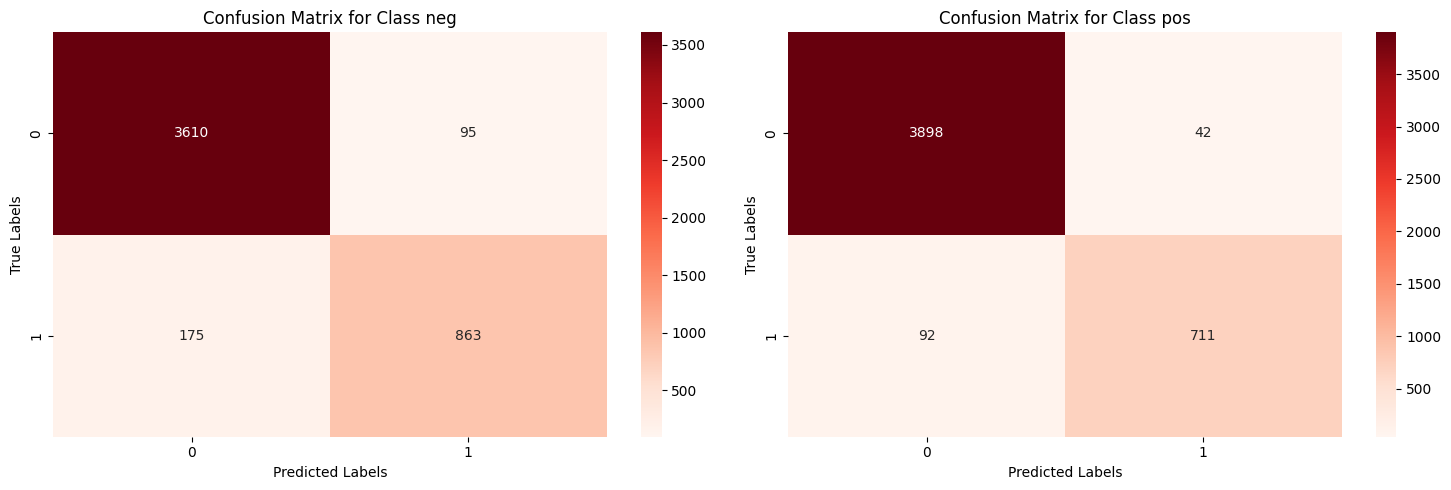

In [53]:
plot_confusion_matrix(y_test.cpu().numpy(), predictions_test.cpu().numpy(), class_labels=['neg', 'pos'])

In [54]:
test_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
test_hamming_distance.update(y_test, predictions_test)

In [55]:
test_hamming_distance.compute()

tensor(0.0379, device='cuda:0')